In [ ]:
data_dir = "/content/drive/MyDrive/Quora-Data/"

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# with open(data_dir + "pre-processing/glove_twiiter_100_max_train", "rb") as f:
#     X_train_max = pickle.load(f)
# with open(data_dir + "pre-processing/glove_twiiter_100_max_test", "rb") as f:
#     X_test_max = pickle.load(f)
with open(data_dir + "pre-processing/glove_twiiter_100_avg_train", "rb") as f:
    X_train_avg = pickle.load(f)
with open(data_dir + "pre-processing/glove_twiiter_100_avg_test", "rb") as f:
    X_test_avg = pickle.load(f)
Y_train = pd.read_csv(data_dir + "pre-processing/train.csv")["Y"].values
Y_test = pd.read_csv(data_dir + "pre-processing/test.csv")["Y"].values
X_train_f = pd.read_csv(data_dir + "pre-processing/features1_2_selected_train.csv").drop(["qid1", "id", "qid2"], axis=1)[["common_word_ratio_proc", "fuzz_rat_proc"]].values
X_test_f = pd.read_csv(data_dir + "pre-processing/features1_2_selected_test.csv").drop(["qid1", "id", "qid2"], axis=1)[["common_word_ratio_proc", "fuzz_rat_proc"]].values

X_train, X_test = np.hstack((X_train_avg, X_train_f)), np.hstack((X_test_avg, X_test_f))

def remove_nan(X, Y):
    Y = Y[~np.isnan(X).any(axis=1)]
    X = X[~np.isnan(X).any(axis=1)]
    return X, Y

X_train, Y_train = remove_nan(X_train, Y_train)
X_test, Y_test = remove_nan(X_test, Y_test)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

X_train_t = torch.from_numpy(X_train.astype('float32'))
X_test_t = torch.from_numpy(X_test.astype('float32'))
X_val_t = torch.from_numpy(X_val.astype('float32'))
Y_train_t = torch.from_numpy(Y_train)
Y_test_t = torch.from_numpy(Y_test)
Y_val_t = torch.from_numpy(Y_val)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []
iteration_list_val = []
iteration_list_train = []
loss_train_epoch = []

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(202, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    #torch.nn.Dropout(0.2),
    torch.nn.Linear(32, 1)
    #torch.nn.Sigmoid()
    #torch.nn.Softmax()
)
# inp_dim = 200
# class Net(nn.Module):
#     def __init__(self, input_shape):
#         super(Net,self).__init__()
#         self.fc1 = nn.Linear(input_shape, 120)
#         self.fc2 = nn.Linear(120, 80)
#         self.fc3 = nn.Linear(80, 1)

#     def forward(self,x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x
# model = Net(input_shape=inp_dim)

model.to(device)
num_epochs = 4
count = 0
batch_size = 100

class MyDataset(Dataset):
    def __init__(self, X, Y, transform = None):
        self.transform = transform
        self.X = torch.tensor(X, dtype=torch.float32) #X
        self.Y = torch.tensor(Y, dtype=torch.float32) #torch.from_numpy(np.asarray(Y).astype('long'))

    def __getitem__(self, index):
        label = self.Y[index]
        image = self.X[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.X)

error = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()

learning_rate = 0.01
# https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.95, weight_decay=0.01)

# After running several times, this was found to be the best
# learning_rate = 0.002
# https://pytorch.org/docs/stable/optim.html
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%1000 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 1000, Val Loss: 417.179, Val Accuracy: 0.633 Train Loss: 1671.067, Train Accuracy: 0.630
Iteration: 2000, Val Loss: 383.452, Val Accuracy: 0.639 Train Loss: 1535.680, Train Accuracy: 0.635
Iteration: 3000, Val Loss: 343.837, Val Accuracy: 0.712 Train Loss: 1375.790, Train Accuracy: 0.714
Iteration: 4000, Val Loss: 327.604, Val Accuracy: 0.725 Train Loss: 1309.687, Train Accuracy: 0.727
Iteration: 5000, Val Loss: 322.281, Val Accuracy: 0.730 Train Loss: 1286.720, Train Accuracy: 0.732
Iteration: 6000, Val Loss: 318.923, Val Accuracy: 0.734 Train Loss: 1272.819, Train Accuracy: 0.735
Iteration: 7000, Val Loss: 316.600, Val Accuracy: 0.736 Train Loss: 1262.801, Train Accuracy: 0.738
Iteration: 8000, Val Loss: 314.739, Val Accuracy: 0.739 Train Loss: 1254.415, Train Accuracy: 0.740
Iteration: 9000, Val Loss: 313.086, Val Accuracy: 0.741 Train Loss: 1246.979, Train Accuracy: 0.743
Iteration: 10000, Val Loss: 311.662, Val Accuracy: 0.743 Train Loss: 1240.332, Train Accuracy: 0.745

In [ ]:
learning_rate = 0.01
# https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.95, weight_decay=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%5000 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 15000, Val Loss: 305.503, Val Accuracy: 0.751 Train Loss: 1212.718, Train Accuracy: 0.755
Iteration: 20000, Val Loss: 301.001, Val Accuracy: 0.757 Train Loss: 1192.156, Train Accuracy: 0.763


In [ ]:
learning_rate = 0.01
# https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.95, weight_decay=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(100):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%5000 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 25000, Val Loss: 297.837, Val Accuracy: 0.761 Train Loss: 1175.905, Train Accuracy: 0.768
Iteration: 30000, Val Loss: 295.466, Val Accuracy: 0.764 Train Loss: 1164.234, Train Accuracy: 0.771
Iteration: 35000, Val Loss: 293.345, Val Accuracy: 0.766 Train Loss: 1153.376, Train Accuracy: 0.775
Iteration: 40000, Val Loss: 291.947, Val Accuracy: 0.769 Train Loss: 1145.629, Train Accuracy: 0.778
Iteration: 45000, Val Loss: 290.766, Val Accuracy: 0.769 Train Loss: 1138.427, Train Accuracy: 0.780
Iteration: 50000, Val Loss: 289.537, Val Accuracy: 0.770 Train Loss: 1132.321, Train Accuracy: 0.782
Iteration: 55000, Val Loss: 288.981, Val Accuracy: 0.771 Train Loss: 1127.778, Train Accuracy: 0.783
Iteration: 60000, Val Loss: 288.678, Val Accuracy: 0.773 Train Loss: 1123.460, Train Accuracy: 0.785
Iteration: 65000, Val Loss: 287.576, Val Accuracy: 0.774 Train Loss: 1119.980, Train Accuracy: 0.786
Iteration: 70000, Val Loss: 287.047, Val Accuracy: 0.774 Train Loss: 1115.805, Train Accura

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(100):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%5000 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 135000, Val Loss: 282.090, Val Accuracy: 0.779 Train Loss: 1080.971, Train Accuracy: 0.796
Iteration: 140000, Val Loss: 281.094, Val Accuracy: 0.780 Train Loss: 1072.604, Train Accuracy: 0.798
Iteration: 145000, Val Loss: 280.661, Val Accuracy: 0.781 Train Loss: 1067.992, Train Accuracy: 0.800
Iteration: 150000, Val Loss: 280.319, Val Accuracy: 0.781 Train Loss: 1065.228, Train Accuracy: 0.800
Iteration: 155000, Val Loss: 279.992, Val Accuracy: 0.781 Train Loss: 1063.206, Train Accuracy: 0.800
Iteration: 160000, Val Loss: 279.691, Val Accuracy: 0.782 Train Loss: 1061.272, Train Accuracy: 0.801
Iteration: 165000, Val Loss: 279.599, Val Accuracy: 0.782 Train Loss: 1059.642, Train Accuracy: 0.801
Iteration: 170000, Val Loss: 279.327, Val Accuracy: 0.783 Train Loss: 1058.281, Train Accuracy: 0.802
Iteration: 175000, Val Loss: 279.162, Val Accuracy: 0.783 Train Loss: 1056.858, Train Accuracy: 0.802
Iteration: 180000, Val Loss: 279.032, Val Accuracy: 0.783 Train Loss: 1055.849, Tr

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.009)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%50 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 19200, Val Loss: 271.640, Val Accuracy: 0.790 Train Loss: 1072.239, Train Accuracy: 0.796
Iteration: 19250, Val Loss: 271.829, Val Accuracy: 0.790 Train Loss: 1072.948, Train Accuracy: 0.796
Iteration: 19300, Val Loss: 271.777, Val Accuracy: 0.790 Train Loss: 1072.418, Train Accuracy: 0.796
Iteration: 19350, Val Loss: 271.987, Val Accuracy: 0.789 Train Loss: 1072.718, Train Accuracy: 0.796
Iteration: 19400, Val Loss: 271.744, Val Accuracy: 0.789 Train Loss: 1072.246, Train Accuracy: 0.796
Iteration: 19450, Val Loss: 271.802, Val Accuracy: 0.789 Train Loss: 1072.101, Train Accuracy: 0.796
Iteration: 19500, Val Loss: 271.784, Val Accuracy: 0.789 Train Loss: 1072.021, Train Accuracy: 0.796
Iteration: 19550, Val Loss: 271.674, Val Accuracy: 0.788 Train Loss: 1072.149, Train Accuracy: 0.796
Iteration: 19600, Val Loss: 271.698, Val Accuracy: 0.789 Train Loss: 1071.870, Train Accuracy: 0.796
Iteration: 19650, Val Loss: 271.534, Val Accuracy: 0.789 Train Loss: 1071.216, Train Accura

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%50 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 21500, Val Loss: 271.005, Val Accuracy: 0.789 Train Loss: 1068.572, Train Accuracy: 0.797
Iteration: 21550, Val Loss: 270.939, Val Accuracy: 0.790 Train Loss: 1068.362, Train Accuracy: 0.797
Iteration: 21600, Val Loss: 270.898, Val Accuracy: 0.790 Train Loss: 1068.191, Train Accuracy: 0.797
Iteration: 21650, Val Loss: 270.910, Val Accuracy: 0.790 Train Loss: 1068.131, Train Accuracy: 0.797
Iteration: 21700, Val Loss: 270.839, Val Accuracy: 0.790 Train Loss: 1067.928, Train Accuracy: 0.797
Iteration: 21750, Val Loss: 270.824, Val Accuracy: 0.790 Train Loss: 1067.792, Train Accuracy: 0.797
Iteration: 21800, Val Loss: 270.793, Val Accuracy: 0.790 Train Loss: 1067.646, Train Accuracy: 0.797
Iteration: 21850, Val Loss: 270.731, Val Accuracy: 0.790 Train Loss: 1067.495, Train Accuracy: 0.797
Iteration: 21900, Val Loss: 270.713, Val Accuracy: 0.790 Train Loss: 1067.364, Train Accuracy: 0.797
Iteration: 21950, Val Loss: 270.653, Val Accuracy: 0.790 Train Loss: 1067.144, Train Accura

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 22500, Val Loss: 270.453, Val Accuracy: 0.790 Train Loss: 1066.121, Train Accuracy: 0.797
Iteration: 23000, Val Loss: 270.136, Val Accuracy: 0.790 Train Loss: 1064.936, Train Accuracy: 0.797
Iteration: 23500, Val Loss: 269.939, Val Accuracy: 0.790 Train Loss: 1063.968, Train Accuracy: 0.797
Iteration: 24000, Val Loss: 269.839, Val Accuracy: 0.790 Train Loss: 1063.384, Train Accuracy: 0.797
Iteration: 24500, Val Loss: 269.810, Val Accuracy: 0.790 Train Loss: 1062.837, Train Accuracy: 0.797
Iteration: 25000, Val Loss: 269.690, Val Accuracy: 0.790 Train Loss: 1062.174, Train Accuracy: 0.798
Iteration: 25500, Val Loss: 269.547, Val Accuracy: 0.791 Train Loss: 1061.494, Train Accuracy: 0.798
Iteration: 26000, Val Loss: 269.373, Val Accuracy: 0.791 Train Loss: 1060.901, Train Accuracy: 0.798
Iteration: 26500, Val Loss: 269.279, Val Accuracy: 0.791 Train Loss: 1060.384, Train Accuracy: 0.798
Iteration: 27000, Val Loss: 269.273, Val Accuracy: 0.791 Train Loss: 1059.932, Train Accura

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(100):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%5000 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 40000, Val Loss: 267.596, Val Accuracy: 0.793 Train Loss: 1050.208, Train Accuracy: 0.801
Iteration: 45000, Val Loss: 267.008, Val Accuracy: 0.794 Train Loss: 1046.590, Train Accuracy: 0.802
Iteration: 50000, Val Loss: 266.460, Val Accuracy: 0.794 Train Loss: 1043.017, Train Accuracy: 0.803
Iteration: 55000, Val Loss: 265.833, Val Accuracy: 0.795 Train Loss: 1039.337, Train Accuracy: 0.804
Iteration: 60000, Val Loss: 265.257, Val Accuracy: 0.796 Train Loss: 1036.073, Train Accuracy: 0.805
Iteration: 65000, Val Loss: 264.677, Val Accuracy: 0.796 Train Loss: 1032.293, Train Accuracy: 0.806
Iteration: 70000, Val Loss: 264.230, Val Accuracy: 0.796 Train Loss: 1029.221, Train Accuracy: 0.806
Iteration: 75000, Val Loss: 263.684, Val Accuracy: 0.798 Train Loss: 1025.842, Train Accuracy: 0.807
Iteration: 80000, Val Loss: 263.175, Val Accuracy: 0.797 Train Loss: 1022.485, Train Accuracy: 0.808
Iteration: 85000, Val Loss: 262.853, Val Accuracy: 0.797 Train Loss: 1019.570, Train Accura

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(100):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%10000 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 290000, Val Loss: 253.133, Val Accuracy: 0.809 Train Loss: 923.914, Train Accuracy: 0.833
Iteration: 300000, Val Loss: 252.421, Val Accuracy: 0.809 Train Loss: 919.320, Train Accuracy: 0.834
Iteration: 310000, Val Loss: 252.207, Val Accuracy: 0.811 Train Loss: 916.362, Train Accuracy: 0.835
Iteration: 320000, Val Loss: 252.303, Val Accuracy: 0.810 Train Loss: 913.561, Train Accuracy: 0.835
Iteration: 330000, Val Loss: 251.906, Val Accuracy: 0.811 Train Loss: 909.717, Train Accuracy: 0.837
Iteration: 340000, Val Loss: 251.691, Val Accuracy: 0.811 Train Loss: 906.462, Train Accuracy: 0.838
Iteration: 350000, Val Loss: 251.573, Val Accuracy: 0.811 Train Loss: 903.222, Train Accuracy: 0.838
Iteration: 360000, Val Loss: 251.903, Val Accuracy: 0.811 Train Loss: 900.872, Train Accuracy: 0.838
Iteration: 370000, Val Loss: 251.334, Val Accuracy: 0.812 Train Loss: 897.561, Train Accuracy: 0.839
Iteration: 380000, Val Loss: 251.052, Val Accuracy: 0.813 Train Loss: 894.245, Train Accura

In [ ]:
learning_rate = 0.000008
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(100):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%15000 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 555000, Val Loss: 249.743, Val Accuracy: 0.814 Train Loss: 854.500, Train Accuracy: 0.850
Iteration: 570000, Val Loss: 249.634, Val Accuracy: 0.815 Train Loss: 851.830, Train Accuracy: 0.850
Iteration: 585000, Val Loss: 249.832, Val Accuracy: 0.814 Train Loss: 849.863, Train Accuracy: 0.850
Iteration: 600000, Val Loss: 249.738, Val Accuracy: 0.814 Train Loss: 847.668, Train Accuracy: 0.851
Iteration: 615000, Val Loss: 249.702, Val Accuracy: 0.813 Train Loss: 846.333, Train Accuracy: 0.852
Iteration: 630000, Val Loss: 249.563, Val Accuracy: 0.814 Train Loss: 844.189, Train Accuracy: 0.852
Iteration: 645000, Val Loss: 249.678, Val Accuracy: 0.814 Train Loss: 842.054, Train Accuracy: 0.853
Iteration: 660000, Val Loss: 249.827, Val Accuracy: 0.814 Train Loss: 840.252, Train Accuracy: 0.853
Iteration: 675000, Val Loss: 249.594, Val Accuracy: 0.814 Train Loss: 837.848, Train Accuracy: 0.853
Iteration: 690000, Val Loss: 249.684, Val Accuracy: 0.814 Train Loss: 836.786, Train Accura

In [ ]:
learning_rate = 0.000008
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(100):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%15000 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 810000, Val Loss: 248.115, Val Accuracy: 0.814 Train Loss: 847.132, Train Accuracy: 0.854
Iteration: 825000, Val Loss: 247.805, Val Accuracy: 0.815 Train Loss: 860.508, Train Accuracy: 0.852
Iteration: 840000, Val Loss: 247.876, Val Accuracy: 0.815 Train Loss: 866.837, Train Accuracy: 0.851
Iteration: 855000, Val Loss: 247.709, Val Accuracy: 0.816 Train Loss: 870.348, Train Accuracy: 0.849
Iteration: 870000, Val Loss: 248.016, Val Accuracy: 0.815 Train Loss: 874.018, Train Accuracy: 0.849
Iteration: 885000, Val Loss: 248.256, Val Accuracy: 0.814 Train Loss: 876.499, Train Accuracy: 0.848
Iteration: 900000, Val Loss: 247.956, Val Accuracy: 0.815 Train Loss: 877.859, Train Accuracy: 0.848


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Training set Loss-Epoch')

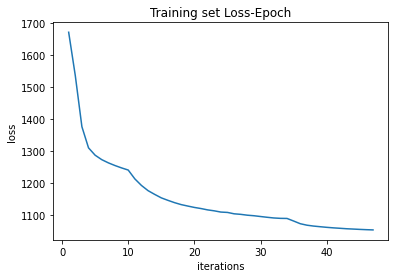

In [ ]:
loss_train_epoch_m = [i.item() for i in loss_train_epoch]
plt.plot([i+1 for i in range(len(iteration_list_train))], loss_train_epoch_m)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("Training set Loss-Epoch")

Text(0.5, 1.0, 'Validation set Loss-iteration')

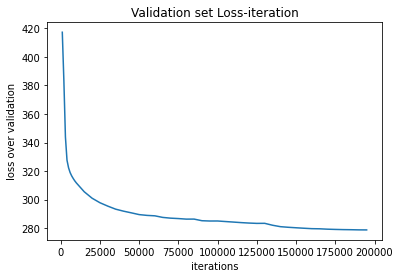

In [ ]:
loss_list_val_m = [i.item() for i in loss_list_val]
plt.plot(iteration_list_val, loss_list_val_m)
plt.xlabel("iterations")
plt.ylabel("loss over validation")
plt.title("Validation set Loss-iteration")

Text(0.5, 1.0, 'Validation set Accuracy-iteration')

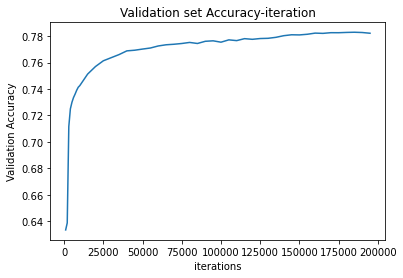

In [ ]:
accuracy_list_val_m = [i for i in accuracy_list_val]
plt.plot(iteration_list_val, accuracy_list_val_m)
plt.xlabel("iterations")
plt.ylabel("Validation Accuracy")
plt.title("Validation set Accuracy-iteration")

Text(0.5, 1.0, 'Training set Accuracy-iteration')

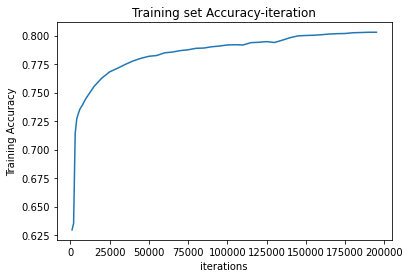

In [ ]:
accuracy_list_train_m = [i for i in accuracy_list_train]
plt.plot(iteration_list_train, accuracy_list_train_m)
plt.xlabel("iterations")
plt.ylabel("Training Accuracy")
plt.title("Training set Accuracy-iteration")

In [ ]:
with open(data_dir + "Models/glove_twitter_avg_manual_features_fc.sav", "wb") as f:
    pickle.dump(model, f)

Test Accuracy: 0.6551352956460413, Test Loss: 615.550048828125
Test Confusion Matrix
Test AUC:  0.6491960311992887


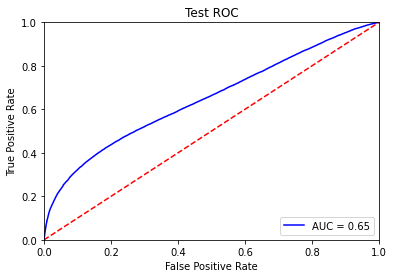

              precision    recall  f1-score   support

         0.0       0.71      0.76      0.74     51093
         1.0       0.54      0.47      0.50     29730

    accuracy                           0.66     80823
   macro avg       0.62      0.62      0.62     80823
weighted avg       0.65      0.66      0.65     80823



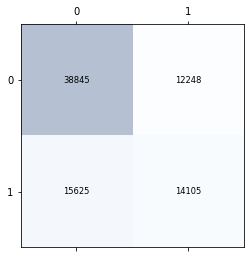

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(test_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Test Accuracy: {}, Test Loss: {}".format(accuracy, loss))
print("Test Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Test AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Test ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

Val Accuracy: 0.7832864256332539, Val Loss: 278.7136535644531
Val Confusion Matrix
Val AUC:  0.8668444966306953


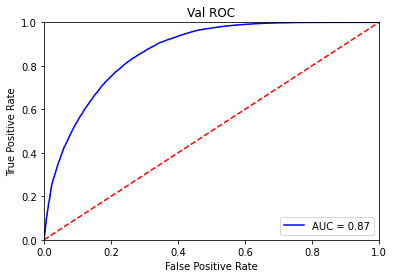

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83     40954
         1.0       0.70      0.71      0.70     23712

    accuracy                           0.78     64666
   macro avg       0.77      0.77      0.77     64666
weighted avg       0.78      0.78      0.78     64666



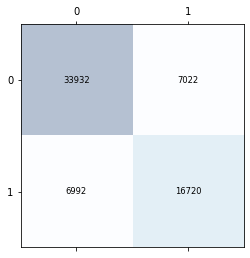

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(val_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Val Accuracy: {}, Val Loss: {}".format(accuracy, loss))
print("Val Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Val AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Val ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

Train Accuracy: 0.8032103671973464, Train Loss: 1052.5423583984375
Train Confusion Matrix
Train AUC:  0.8862286298528249


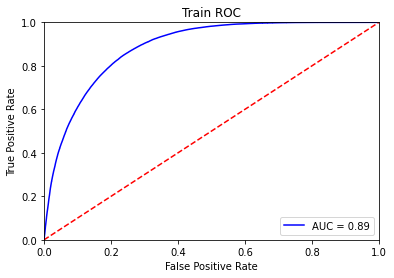

              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84    162845
         1.0       0.74      0.73      0.73     95817

    accuracy                           0.80    258662
   macro avg       0.79      0.79      0.79    258662
weighted avg       0.80      0.80      0.80    258662



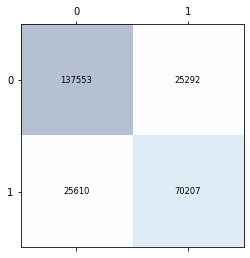

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(train_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Train Accuracy: {}, Train Loss: {}".format(accuracy, loss))
print("Train Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Train AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Train ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

In [ ]:
interm_model = nn.Sequential(*list(model.children())[:-1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


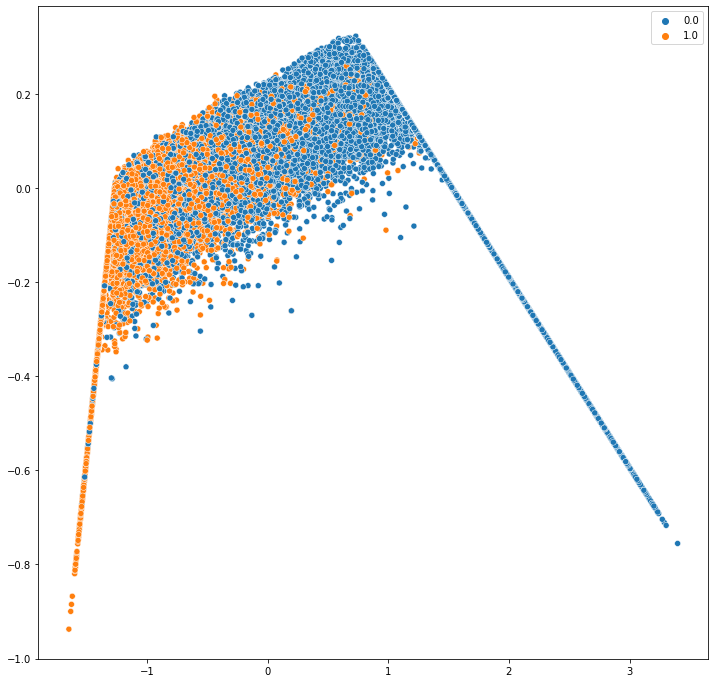

In [ ]:
total = 0
correct = 0
loss = 0
out = []
labels_l = []
for images, labels in DataLoader(val_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = interm_model(test)
    labels_l.append(labels)
    out.append(outputs)

class pca:
    def __init__(self, n_components):
        """
        :param n_components: Number of principal components the data should be reduced too.
        """
        self.components = n_components

    def fit_transform(self, X):
        """
        * Centering our inputs with mean
        * Finding covariance matrix using centered tensor
        * Finding eigen value and eigen vector using torch.eig()
        * Sorting eigen values in descending order and finding index of high eigen values
        * Using sorted index, get the eigen vectors
        * Tranforming the Input vectors with n columns into PCA components with reduced dimension
        :param X: Input tensor with n columns.
        :return: Output tensor with reduced principal components
        """
        centering_X = X - torch.mean(X, dim=0)
        covariance_matrix = torch.mm(centering_X.T, centering_X)/(centering_X.shape[0] - 1)
        eigen_values, eigen_vectors = torch.eig(covariance_matrix, eigenvectors=True)
        eigen_sorted_index = torch.argsort(eigen_values[:,0],descending=True)
        eigen_vectors_sorted = eigen_vectors[:,eigen_sorted_index]
        component_vector = eigen_vectors_sorted[:,0:self.components]
        transformed = torch.mm(component_vector.T, centering_X.T).T
        return transformed
pca_out = pca(n_components=2).fit_transform(torch.cat(out))
pca_vector = pca_out
plt.figure(figsize=(12, 12))
sb.scatterplot(
    pca_vector[:, 0].detach().cpu(), 
    pca_vector[:, 1].detach().cpu(), 
    hue=torch.cat(labels_l).detach().cpu(), 
    #s=100, 
    palette="tab10"
)
plt.show()

In [ ]:
df_val_samp = pd.DataFrame(X_val).join(pd.Series(Y_val, name="Y")).sample(n=100).reset_index(drop=True)
X_val_samp = torch.from_numpy(df_val_samp.drop("Y", axis=1).values.astype("float32"))
Y_val_samp = torch.from_numpy(df_val_samp["Y"].values.astype("float32"))

In [ ]:
Y_pred = model(X_val_samp.to(device))
Y_pred_lab = torch.round(torch.sigmoid(Y_pred)).reshape(-1)

In [ ]:
X_val_samp[Y_pred_lab != Y_val_samp]

RuntimeError: ignored